# Astronomy Deep Learning with RNN's
## An exploration of how to work with irregular data
Authored By Wesley Giles

Data Courtesy of Dom Rowan and the [ASAS-Sn](https://asas-sn.osu.edu/) Team

[Shappee et al. (2014)](http://adsabs.harvard.edu/abs/2014ApJ...788...48S)

The Value-Added Catalog of ASAS-SN Eclipsing Binaries II [Rowan et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022arXiv221006486R/abstract)

## Import Modules and Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

df = pd.read_csv("data/ep_database_table.csv")
df.head()

,id,asassn_name,source,TIC,RA_ICRS,DE_ICRS,period,p2,p2_method_i,group,...,gaia_filter,state,r1,xray_source,xray_observatory,xray_citation_key,xray_ads_link,xray_exposure,xray_luminosity,xray_separation
0,19740550,ASASSN-V J073404.84-172018.6,3027086769773339136,259217758,113.520431,-17.337925,2.290736,1.020633,3,extra_eclipses,...,True,ms,34.1,False,NaN,NaN,NaN,NaN,NaN,NaN
1,12404851,ASASSN-V J210203.83+413206.9,1969506323593523968,314302488,315.514880,41.535265,1.917353,4.456349,0,extra_eclipses,...,True,sg,17.4,False,NaN,NaN,NaN,NaN,NaN,NaN
2,48477157,ASASSN-V J160011.64-551631.8,5836598635367073536,423100302,240.046116,-55.273951,11.335355,NaN,99,extra_eclipses,...,True,rg,19.0,False,NaN,NaN,NaN,NaN,NaN,NaN
3,40537394,ASASSN-V J105824.26-611350.7,5337975437890183168,465899856,164.599460,-61.229444,12.994970,2.330673,1,extra_eclipses,...,False,NaN,25.7,False,NaN,NaN,NaN,NaN,NaN,NaN
4,38696380,ASASSN-V J105907.86-620142.6,5241801705576197248,465971173,164.781648,-62.028066,1.261505,1.283047,1,extra_eclipses,...,False,NaN,10.4,False,NaN,NaN,NaN,NaN,NaN,NaN


### We should also unzip the tarball if we haven't already

In [5]:
import os
if "ep_database_lightcurves.tar.gz" not in os.listdir("data"):
    !pip install gdown
    import gdown
    gdown.download("https://drive.google.com/file/d/1PNCIJIFvqg5Z_dryiWTWXfe3nF9_3Jg8", "data/ep_database_lightcurves.tar.gz")
if "lightcurves" not in os.listdir("data"):
    !mkdir data\lightcurves && tar -xf data\ep_database_lightcurves.tar.gz -C data\lightcurves --strip-components 1
print(f"{len(os.listdir('data/lightcurves'))} light curve files are now in data/lightcurves! (should be {df.shape[0]})")

     -------------------------------------- 143.0/143.0 kB 4.3 MB/s eta 0:00:00


c:\Users\wesle\anaconda3\envs\ml_standard\lib\site-packages\gdown\parse_url.py:44: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1PNCIJIFvqg5Z_dryiWTWXfe3nF9_3Jg8
To: c:\Users\wesle\Desktop\AstroLearning\data\ep_database_lightcurves.tar.gz
81.7kB [00:00, ?B/s]

766 light curve files are now in data/lightcurves! (should be 766)


### Now that our data is unzipped let's take a look at a random light curve file

Looking at target with id: 19823557


,hjd,phase,mag,mag_err,filter,sector,phase2,mag2
0,2.457010e+06,0.349991,12.594000,0.020000,V,NaN,NaN,NaN
1,2.457011e+06,0.001600,12.469000,0.020000,V,NaN,NaN,NaN
2,2.457012e+06,0.726179,12.476000,0.020000,V,NaN,NaN,NaN
3,2.457022e+06,0.349742,12.515000,0.020000,V,NaN,NaN,NaN
4,2.457038e+06,0.021091,12.465000,0.020000,V,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4915,2.459252e+06,0.413789,12.481270,0.031787,T,34.0,0.727282,0.040161
4916,2.459252e+06,0.418400,12.477747,0.031684,T,34.0,0.739951,0.040546
4917,2.459252e+06,0.423011,12.477203,0.031668,T,34.0,0.752620,0.038716
4918,2.459252e+06,0.427623,12.476132,0.031637,T,34.0,0.765289,0.037933


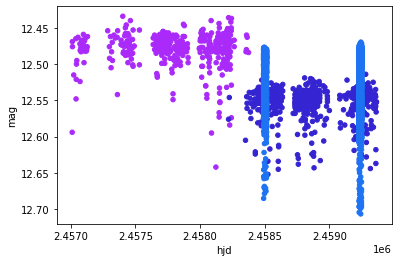

In [134]:
from random import choice
def show_random_lightcurve(df: pd.DataFrame, plot = False) -> pd.DataFrame:
    rand_target_id = df.loc[choice(df.index),"id"]
    print(f"Looking at target with id: {rand_target_id}")
    rand_df = pd.read_csv(f"data/lightcurves/{rand_target_id}.csv")
    if plot:
        colors = {"T":"#1d73f2", "g": "#3524d1", "V":"#aa2afa"}
        rand_df.plot.scatter(x="hjd", y="mag", c=rand_df["filter"].map(colors))
        plt.gca().invert_yaxis()
    return rand_df

show_random_lightcurve(df, True)

### Cool! you may think you understand what the lightcurve files' structure is now, however it may surprise you that there are actually 3 different formats for these files!
- If there is no Tess lightcurve data (indicated by the boolean `has_tess`) there will be only 5 columns
- If there is Tess lightcurve data but the system doen't have a second period it will also have the column `sector`
- If there is Tess lightcurve data and the system *does* have a second period it will have the column `sector` as well as two more `phase2` and `mag2`

We need a way to process all these data varieties, but lets start by viewing them

#### Let's start by setting up some filters

In [122]:
tess_filter = df["has_tess"] == True
second_period_filter = df["p2"].isna() == False

#### Now let's view some curves!

Looking at target with id: 30504604


,hjd,phase,mag,mag_err,filter
0,2.457106e+06,0.866505,13.913,0.02330,V
1,2.457109e+06,0.227742,14.026,0.02411,V
2,2.457110e+06,0.347354,13.984,0.02379,V
3,2.457111e+06,0.467860,14.011,0.02399,V
4,2.457137e+06,0.597560,13.923,0.02336,V
...,...,...,...,...,...
378,2.459403e+06,0.549355,14.314,0.02775,g
379,2.459404e+06,0.667545,14.296,0.02742,g
380,2.459408e+06,0.140439,14.466,0.03000,g
381,2.459412e+06,0.637803,14.314,0.02706,g


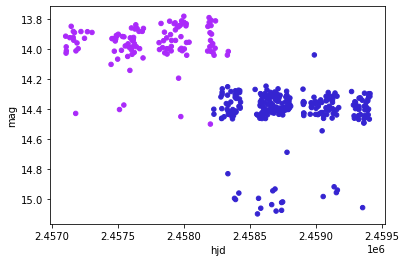

In [136]:
show_random_lightcurve(df[~tess_filter], True)

Looking at target with id: 49368268


,hjd,phase,mag,mag_err,filter,sector
0,2.457458e+06,0.942061,12.830000,0.020000,V,NaN
1,2.457462e+06,0.850622,12.828000,0.020000,V,NaN
2,2.457466e+06,0.743212,12.829000,0.020000,V,NaN
3,2.457477e+06,0.241368,12.802000,0.020000,V,NaN
4,2.457479e+06,0.657043,12.814000,0.020000,V,NaN
...,...,...,...,...,...,...
4485,2.459360e+06,0.995955,12.176768,0.013621,T,38.0
4486,2.459360e+06,0.997517,12.170471,0.013543,T,38.0
4487,2.459360e+06,0.999080,12.169021,0.013525,T,38.0
4488,2.459360e+06,0.000642,12.162369,0.013442,T,38.0


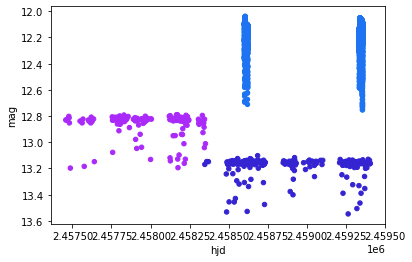

In [137]:
show_random_lightcurve(df[tess_filter & ~second_period_filter], True)

Looking at target with id: 40400072


,hjd,phase,mag,mag_err,filter,sector,phase2,mag2
0,2.457421e+06,0.195895,12.948000,0.020000,V,NaN,NaN,NaN
1,2.457424e+06,0.144079,12.925000,0.020000,V,NaN,NaN,NaN
2,2.457428e+06,0.332487,12.963000,0.020000,V,NaN,NaN,NaN
3,2.457438e+06,0.322154,12.928000,0.020000,V,NaN,NaN,NaN
4,2.457441e+06,0.264622,12.922000,0.020000,V,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
8877,2.459360e+06,0.575986,12.251826,0.029352,T,38.0,0.400460,-0.153311
8878,2.459360e+06,0.578082,12.248024,0.029250,T,38.0,0.403054,-0.150360
8879,2.459360e+06,0.580178,12.230611,0.028784,T,38.0,0.405648,-0.136713
8880,2.459360e+06,0.582273,12.221172,0.028535,T,38.0,NaN,NaN


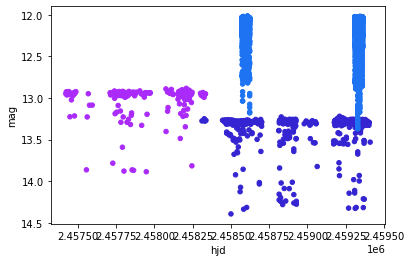

In [149]:
show_random_lightcurve(df[tess_filter & second_period_filter], True)


#### There are even some lightcurves that don't follow these rules. In general we won't be using the `phase2` and `mag2` columns, and the `sector` isn't much help for us either so let's make a function to return a dataframe with only the original 5 columns

In [161]:
columns = ["hjd", "phase", "mag", "mag_err", "filter"]
def get_trunc_lightcurve(id: str) -> pd.DataFrame:
    return pd.read_csv(f"data/lightcurves/{id}.csv")[columns]

get_trunc_lightcurve(df.loc[choice(df.index),"id"])

,hjd,phase,mag,mag_err,filter
0,2.456790e+06,0.150789,12.117000,0.020000,V
1,2.456795e+06,0.033998,12.146000,0.020000,V
2,2.456805e+06,0.783857,12.090000,0.020000,V
3,2.456811e+06,0.618828,12.139000,0.020000,V
4,2.456815e+06,0.526470,12.299000,0.020000,V
...,...,...,...,...,...
5474,2.458381e+06,0.146908,11.615142,0.000790,T
5475,2.458381e+06,0.167250,11.613941,0.000788,T
5476,2.458381e+06,0.187592,11.611986,0.000786,T
5477,2.458381e+06,0.207934,11.612502,0.000785,T


#### And a function to break up the datafram by it's `filter` column

In [165]:
def split_curve_by_filter(df: pd.DataFrame) -> tuple[pd.DataFrame]:
    return (df.loc[df["filter"] == "V"],df.loc[df["filter"] == "g"],df.loc[df["filter"] == "T"])

trunc_df = get_trunc_lightcurve(df.loc[choice(df.index),"id"])
v_df, g_df, t_df = split_curve_by_filter(trunc_df)
print(v_df.shape, "+")
print(g_df.shape, "+")
print(t_df.shape, "=")
print(trunc_df.shape)
print(v_df.shape[0] + g_df.shape[0] + t_df.shape[0] == trunc_df.shape[0])

(129, 5) +
(442, 5) +
(5691, 5) =
(6262, 5)
True


In [172]:
class LightCurve:
    def __init__(self, df: pd.DataFrame):
        self.df = df

In [183]:
def encode_light_curves(lcs):
    return pd.Series([l for l in lcs])

In [184]:
df[["v_lc","g_lc","t_lc"]] = df["id"].apply(lambda x: encode_light_curves(split_curve_by_filter(get_trunc_lightcurve(x))))

In [201]:
for filter in ["v","g","t"]:
  df[f"{filter}_epochs"] = df[f"{filter}_lc"].apply(lambda x: x.shape[0])

df.describe()

,source,TIC,RA_ICRS,DE_ICRS,period,p2,p2_method_i,Gmag,absolute_g,bp_rp,...,mwdust_ag,mwdust_abp,mwdust_arp,r1,xray_exposure,xray_luminosity,xray_separation,v_epochs,g_epochs,t_epochs
count,7.660000e+02,7.660000e+02,766.000000,766.000000,766.000000,620.000000,766.000000,766.000000,755.000000,766.000000,...,755.000000,755.000000,755.000000,766.000000,71.000000,6.300000e+01,74.000000,766.000000,766.000000,766.000000
mean,3.780809e+18,2.487286e+08,171.157906,-8.922947,5.343793,4.682391,70.113577,12.844622,2.123124,1.059837,...,0.564955,0.717471,0.421747,86.685901,15075.436620,2.478490e+36,4.235236,239.231070,501.204961,4320.408616
std,2.037894e+18,1.615744e+08,94.026561,44.547393,6.620666,5.877185,44.543158,0.961178,2.080119,0.376986,...,0.664321,0.843663,0.495925,28.405016,31164.748188,1.587399e+37,3.008023,104.679892,259.510763,5423.206821
min,1.815569e+15,1.478849e+06,1.731284,-85.751523,0.154528,0.103718,0.000000,9.800781,-7.120966,-0.383593,...,0.000000,0.000000,0.000000,0.900000,6.000000,6.523327e+29,0.129801,69.000000,62.000000,0.000000
25%,2.055664e+18,1.248435e+08,99.466261,-48.877631,1.923788,1.192431,2.250000,12.234880,1.042305,0.829080,...,0.126966,0.161242,0.094782,99.900000,449.500000,5.162258e+30,1.915166,167.000000,311.000000,1139.250000
50%,4.032170e+18,2.567774e+08,150.717316,-16.241641,3.704278,3.336394,99.000000,12.984334,2.301973,1.076343,...,0.359737,0.456852,0.268549,99.900000,1992.000000,2.297446e+31,3.478028,216.000000,438.000000,3816.000000
75%,5.618501e+18,3.604623e+08,254.232702,34.999431,6.489514,6.186934,99.000000,13.572943,3.163612,1.294339,...,0.776299,0.985870,0.579519,99.900000,11824.500000,8.389199e+31,6.212503,280.750000,635.750000,4876.000000
max,6.813551e+18,1.919623e+09,359.225451,87.120105,93.634400,78.145326,99.000000,15.336974,7.793712,2.450179,...,6.479253,8.228405,4.836857,99.900000,170281.000000,1.232133e+38,9.962488,704.000000,1538.000000,52931.000000


In [213]:
v_size = df["v_epochs"].max()
print(f"V band Dataframes should be normalized to {v_size} rows")
g_size = df["g_epochs"].max()
print(f"g band Dataframes should be normalized to {g_size} rows")
t_size = df["t_epochs"].max()
print(f"Tess Dataframes should be normalized to {t_size} rows")

V band Dataframes should be normalized to 704 rows
g band Dataframes should be normalized to 1538 rows
Tess Dataframes should be normalized to 52931 rows


In [217]:
from sklearn.model_selection import train_test_split

X = df.drop("group", axis=1)
y = df["group"]

X.columns

Index(['id', 'asassn_name', 'source', 'TIC', 'RA_ICRS', 'DE_ICRS', 'period',
       'p2', 'p2_method_i', 'has_tess', 'tess_sectors', 'Gmag', 'absolute_g',
       'bp_rp', 'bp_rp_corrected', 'parallax_over_error', 'rpgeo', 'mwdust_av',
       'mwdust_ag', 'mwdust_abp', 'mwdust_arp', 'gaia_filter', 'state', 'r1',
       'xray_source', 'xray_observatory', 'xray_citation_key', 'xray_ads_link',
       'xray_exposure', 'xray_luminosity', 'xray_separation', 'v_lc', 'g_lc',
       't_lc', 'v_epochs', 'g_epochs', 't_epochs'],
      dtype='object')

In [219]:
categories = y.unique()
categories

array(['extra_eclipses', 'spots', 'reflection', 'other', 'sto_var',
       'irregular_pulsator', 'regular_pulsator'], dtype=object)

In [220]:
X_train, X_test, y_train, y_test = train_test_split(
              X, y, test_size=0.25)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(574, 37)
(192, 37)
(574,)
(192,)
